# Projet de fin de majeure : Super résolution
#### Johanna Dubos, Zoé Ducourau & Dimitri Szezurek
---

In [1]:
# Librairies
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil as shutil
import itk

from utils import *

#### Image considérée (échelle de Monoyer)

Taille de l'image : Hauteur =  1024 || Largeur =  1024


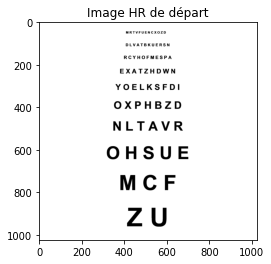

In [2]:
filename = 'Monoyer-square.png'

IMAGE_nb = cv2.imread(filename,0)
#IMAGE_nb = cv2.resize(IMAGE_nb, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
[H,W] = IMAGE_nb.shape

print("Taille de l'image : Hauteur = ", H, "|| Largeur = " , W)

plt.imshow(IMAGE_nb, cmap='gray')
plt.title('Image HR de départ')
plt.show()

#### Création de la BDD avec N images (déformées, floutées, sous-échantillonées & bruitées)

In [3]:
if os.path.exists('BDD'):
    shutil.rmtree('BDD')

os.makedirs('BDD')

In [4]:
N = 10 # Nb d'images dans la BDD
sampling_rate = 8
gaussian_kernel_size = 11

M = []

for i in range (0,N):

    if i == 0:
        img_blurred = cv2.GaussianBlur(IMAGE_nb, (gaussian_kernel_size,gaussian_kernel_size), 0) # Floutage
        img_downsampled = decimation(img_blurred, sampling_rate) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,5,img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR.png",img_noisy,cmap='gray')

    else:
        t_max = 10
        angle = np.random.randint(-10,10)
        rotation = cv2.getRotationMatrix2D((W/2,H/2), angle, 1) # Matrice de rotation
        translation = [np.random.uniform(-t_max,t_max), np.random.uniform(-t_max,t_max)]
        rigid = rotation
        rigid[0,2] += translation[0]
        rigid[1,2] += translation[1]
        img_transformed = cv2.warpAffine(IMAGE_nb, rigid, (W,H)) # Rotation + translation
        img_blurred = cv2.GaussianBlur(img_transformed, (gaussian_kernel_size,gaussian_kernel_size), 0)# Floutage 
        img_downsampled = decimation(img_transformed, sampling_rate) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,5,img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR_"+str(i-1)+".png",img_noisy,cmap='gray')
        
        M_current = np.copy(rigid)
        
        # Matrice de transformation
        M.append(M_current)

#### Différentes étapes :
- Recalage/estimation du mouvement des images BR
- Estimation du flou des images BR
- Sélection d'un a priori convenable
- Estimation d'une image HR


## Recalage des images de la BDD

BDD/imageBR_0.png
BDD/imageBR_1.png
BDD/imageBR_2.png
BDD/imageBR_3.png
BDD/imageBR_4.png
BDD/imageBR_5.png


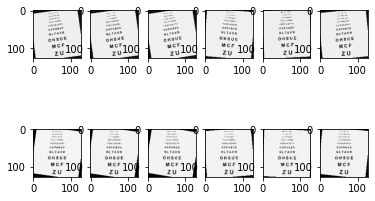

In [5]:
# Nombre d'images à recaler (inferieur strictement à N)
N_registration = 6

M_itk = [] # Liste de transformations

fixed_img = itk.imread('BDD/imageBR.png', itk.UC)

optimizer = itk.RegularStepGradientDescentOptimizer.New() # Instance de la classe d'optimiseur choisie
optimizer.SetMaximumStepLength(0.01) # Borne supérieure du pas de descente (en pixel)
optimizer.SetMinimumStepLength(0.01) # Borne inférieure du pas de descente (en pixel)
optimizer.SetNumberOfIterations(5000) # Nombre maximal d'itération
scales= [180/np.pi,0.5,0.5,0.5,0.5]
optimizer.SetScales(scales) # Nombre maximal d'itération

f=[]
def getMetricValue():
    f.append(optimizer.GetValue())

optimizer.AddObserver(itk.IterationEvent(), getMetricValue)
plt.figure(1)
for i in range(0, N_registration):
    print('BDD/imageBR_' + str(i) + '.png')  
    moving_img = itk.imread('BDD/imageBR_' + str(i) + '.png', itk.UC)
    transform = get_transform_ITK(fixed_img, moving_img, optimizer, sampling_rate)
    M.append(transform)
           
    plt.subplot(2,N_registration,i+1)
    plt.imshow(moving_img, cmap='gray')
    plt.subplot(2,N_registration,N_registration+i+1)
    resample_filter =itk.ResampleImageFilter[fixed_img,moving_img].New() #
    resample_filter.SetInput( moving_img ) # Image d'entrée
    resample_filter.SetTransform(transform)
    resample_filter.SetSize(fixed_img.GetLargestPossibleRegion().GetSize())
    recale = resample_filter.GetOutput()
    plt.imshow(recale, cmap='gray')

In [6]:
# M_test = get_transformation(fixed_img, moving_img, sampling_rate)
# plt.imshow(fixed_img, cmap = 'gray')
# interpolated = interpolation(moving_img, 2)

# moving_img = interpolation(moving_img, sampling_rate)
# registered_img = cv2.warpPerspective(moving_img, M_test, (moving_img.shape[1], moving_img.shape[0]))
# unregistered_img = cv2.warpPerspective(registered_img, M_test, (registered_img.shape[1], registered_img.shape[0]), flags = cv2.WARP_INVERSE_MAP)

# plt.subplot(141)
# plt.imshow(fixed_img, cmap='gray')
# plt.axis('off')

# plt.subplot(142)
# plt.imshow(moving_img, cmap='gray')
# plt.axis('off')

# plt.subplot(143)
# plt.imshow(registered_img, cmap='gray')
# plt.axis('off')

# plt.subplot(144)
# plt.imshow(unregistered_img, cmap='gray')
# plt.axis('off')

Text(0.5, 1.0, "crop zone d'intérêt")

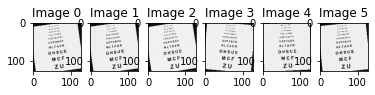

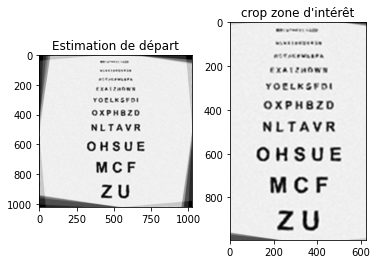

In [7]:
Y = []

Y_reference = cv2.imread('BDD/imageBR.png', 0)
plt.figure(1)
X_0 = np.zeros((np.shape(Y_reference)[0] * sampling_rate, np.shape(Y_reference)[1] * sampling_rate))
for k in range(N_registration):
      Y_current = cv2.imread('BDD/imageBR_' + str(k) + '.png', 0)
      Y.append(Y_current)
      X_0 += recalage_ideal(X_0, Y_current, M[k])
      plt.subplot(1, N_registration, k+1)
      plt.imshow(Y_current, cmap = 'gray')
      plt.title("Image " + str(k))

X_0 /= N_registration # normalisation
X_k = np.copy(X_0)

plt.figure(2)
plt.subplot(121)
plt.imshow(X_k, cmap = 'gray')
plt.title("Estimation de départ")
plt.subplot(122)
plt.imshow(X_0[15:-15,200:-200], cmap='gray')
plt.title("crop zone d'intérêt")



Text(0.5, 1.0, 'Image reconstruite')

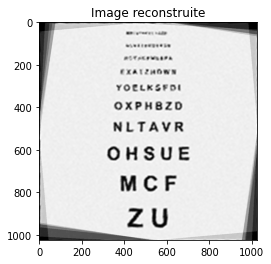

In [8]:
# super resolution gradient descent
X_k = np.copy(X_0)
Z_k = np.zeros((np.shape(X_k)[0], np.shape(X_k)[1]))

list_MSE = [10000000000, 1000000000]
# condition d'arret
epsilon = 0.5

# parametres descente de gradient
beta = 1 # pas de descente
l = 0.5 # lambda

# parametres ADMM (prox)
mu = 0.1
gamma = 0.1

# parametres regul TV
gaussian_kernel = 1/16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
laplacian_kernel = 1/8 * np.array([[1, 1,  1], [1, -8, 1], [1, 1,  1]]) # Laplacian kernel
I = np.identity(3)

# parametres regul bilateral TV
P = 3 
alpha = 0.6

while list_MSE[-2] - list_MSE[-1]> epsilon:
    
    gradient = np.zeros(np.shape(X_k)) 
    
    for k in range(N_registration):
        # gradient
        gradient += G2(X_k, Y[k], M[k], gaussian_kernel_size, sampling_rate)         
        
    # regularization
    # regularization = TV(X_k, gamma)
    # regularization = bilateral_TV(X_k, alpha, P)
    
    #X_k = X_k - beta * (gradient + l * regularization)
    
    regularization_Z =  dX_bilateral_TV(X_k, Z_k, alpha, P)
        
    X_k = X_k - gamma * (gradient - mu * regularization_Z)    
    Z_k = G_D_prox_bilateral_TV(X_k, Z_k, alpha, P, l, gamma)
    
    
    # Mean square error
    MSE_current = MSE(X_k[15:-15,200:-200], IMAGE_nb[15:-15,200:-200])
    list_MSE.append(MSE_current)
    

plt.figure()
plt.imshow(X_k, cmap = 'gray', vmin=0, vmax=255)
plt.title("Image reconstruite")


(-0.5, 1023.5, 1023.5, -0.5)

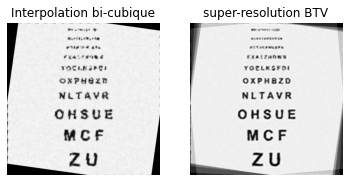

In [9]:
img_interpolated_bicubic = cv2.warpAffine(cv2.resize(Y[0], X_0.shape), M[0], np.shape(X_0), flags=cv2.WARP_INVERSE_MAP)

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(img_interpolated_bicubic, cmap='gray')
plt.title('Interpolation bi-cubique')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_k, cmap='gray', vmin=0, vmax=255)
plt.title('super-resolution BTV')
plt.axis('off')


### Métriques

X_0 (interpolation bicubique moyenne)
MSE : 833
PSNR : 18
Correlation coefficient : [[1.         0.66319185]
 [0.66319185 1.        ]]
 
interpolation bicubique
MSE : 2403
PSNR : 31
Correlation coefficient : [[1.         0.53916146]
 [0.53916146 1.        ]]
 
super résolution
MSE : 821
PSNR : 18
Correlation coefficient : [[1.         0.66980793]
 [0.66980793 1.        ]]


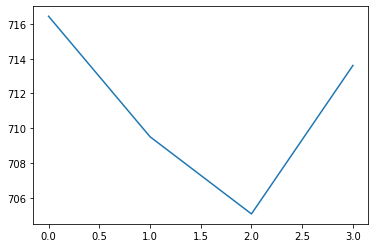

In [10]:
# MSE

plt.figure()
plt.plot(list_MSE[2:])

print("X_0 (interpolation bicubique moyenne)")
print("MSE : " + str(int(MSE(X_0[15:-15,50:-50],IMAGE_nb[15:-15,50:-50]))))
print("PSNR : " + str(int(PSNR(X_0[15:-15,50:-50],IMAGE_nb[15:-15,50:-50]))))
print("Correlation coefficient : " + str(CC(X_0[15:-15,50:-50], IMAGE_nb[15:-15,50:-50])))
print(" ")

print("interpolation bicubique")
print("MSE : " + str(int(MSE(img_interpolated_bicubic[15:-15,50:-50], IMAGE_nb[15:-15,50:-50])**2)))
print("PSNR : " + str(int(PSNR(img_interpolated_bicubic[15:-15,50:-50],IMAGE_nb[15:-15,50:-50]))))
print("Correlation coefficient : " + str(CC(img_interpolated_bicubic[15:-15,50:-50], IMAGE_nb[15:-15,50:-50])))
print(" ")

print("super résolution")
print("MSE : " + str(int(MSE(X_k[15:-15,50:-50], IMAGE_nb[15:-15,50:-50]))))
print("PSNR : " + str(int(PSNR(X_k[15:-15,50:-50],IMAGE_nb[15:-15,50:-50]))))
print("Correlation coefficient : " + str(CC(X_k[15:-15,50:-50], IMAGE_nb[15:-15,50:-50])))



In [11]:
plt.imsave("super_resolution.png", X_k,cmap='gray', vmin=0, vmax=255)
plt.imsave("bicubic_moy.png", X_0, cmap='gray', vmin=0, vmax=255)
plt.imsave("bicubic.png", img_interpolated_bicubic, cmap='gray', vmin=0, vmax=255)

Text(0.5, 1.0, 'Histogramme interpolation bicubique')

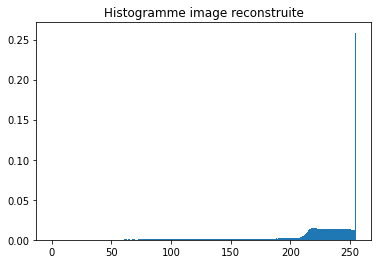

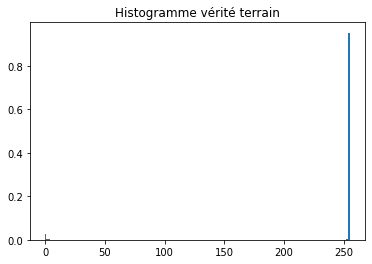

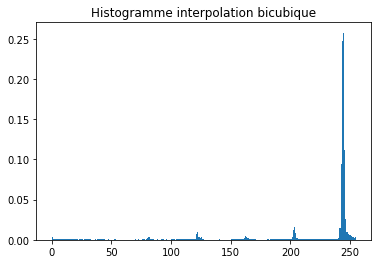

In [30]:
# histogrammes

plt.figure()
thresh, X_k_thresh = cv2.threshold(X_k, 255, 255, cv2.THRESH_TRUNC)
hist_Xk = plt.hist(X_k_thresh.ravel(), bins = 255, range=[0, np.max(X_k_thresh)], density=True)
plt.title("Histogramme image reconstruite")

plt.figure()
hist_GT = plt.hist(IMAGE_nb.ravel(), bins = 255, range=[0, np.max(IMAGE_nb)], density=True)
plt.title("Histogramme vérité terrain")

plt.figure()
thresh, X_0_thresh = cv2.threshold(X_0, 255, 255, cv2.THRESH_TRUNC)
hist_X0 = plt.hist(X_0_thresh.ravel(), bins = 255, range=[0, np.max(X_0_thresh)], density=True)
plt.title("Histogramme interpolation bicubique")


In [25]:
# entropie conjointe
H_Xk_GT = joint_entropy(X_k[15:-15,50:-50], IMAGE_nb[15:-15,50:-50])
H_GT_Xk = joint_entropy(IMAGE_nb[15:-15,50:-50], X_k[15:-15,50:-50])
H_X0_GT = joint_entropy(X_0[15:-15,50:-50], IMAGE_nb[15:-15,50:-50])
H_GT_X0 = joint_entropy(IMAGE_nb[15:-15,50:-50], X_0[15:-15,50:-50])
H_bicubic_GT = joint_entropy(img_interpolated_bicubic[15:-15,50:-50], IMAGE_nb[15:-15,50:-50])
#H_GT_GT = joint_entropy(IMAGE_nb[15:-15,50:-50], IMAGE_nb[15:-15,50:-50])

# entropie
H_GT = entropy(IMAGE_nb[15:-15,50:-50])
H_Xk = entropy(X_k[15:-15,50:-50])
H_X0 = entropy(X_0[15:-15,50:-50])
H_bicubic = entropy(img_interpolated_bicubic[15:-15,50:-50])

# information mutuelle
I_Xk_GT = H_Xk + H_GT - H_Xk_GT
I_X0_GT = H_X0 + H_GT - H_X0_GT
I_bicubic_GT = H_bicubic + H_GT - H_bicubic_GT
#I_GT_GT = H_GT + H_GT - H_GT_GT